# Correlation analysis and feature combining to target a country's scientific output

In this notebook, I'm striving to **build combined features** as correlated as possible with a particular target. To do so, I will first analyze correlation coefficients between features in the raw data space and then apply dimensionality reduction techniques such as **Principal Component Analysis (PCA) and Canonical Correlation Analysis (CCA)** to extract new combined features.

The final dataset (after cleaning and merging operations),  contains for each country: its  energy indicators (Energy Supply, % Renewable,...), its GDP and some statistics regarding energy-related documents that have been published by this country. In these statistics, there are the amount of released documents in Energy, the amount of citations that those documents have been subject to... The **amount of documents** is what we will target in a first place.


**Datasets** : 
- Statistics on Energy-related documents published by each country for the year 2013 from the [Sciamgo Journal and Country Rank data for Energy Engineering and Power Technology](http://www.scimagojr.com/countryrank.php?category=2102) and under the file `scimagojr-3.xlsx`.

The columns here are :

    - Documents: Number of documents published during 2013. It is usually called the country's scientific output.
    - Citable Documents: Selected year citable documents. Exclusively articles, reviews and conference papers considered.
    - Citations: Number of citations by the documents published during 2013. citations in years 2013, 2014, 2015...
    - Citations per Document: Average citations per document published during 2013
    - Self Citations: Country self-citations: Number of self-citations 
    - H index: Country's number of articles (h) that have received at least h citations. It quantifies both country scienti- fic productivity and scientific impact and it is also applicable to scientists, journals, etc


- `Energy Indicators.xls`, is a list of indicators of energy supply and renewable electricity production for +150 countries from the [United Nations](http://unstats.un.org/unsd/environment/excel_file_tables/2013/Energy%20Indicators.xls) for the year 2013

- GDP data from the file `world_bank.csv`, which is a csv containing countries' GDP from 1960 to 2015 from [World Bank](http://data.worldbank.org/indicator/NY.GDP.MKTP.CD). We will be interested by GDPs for the year 2013.



In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
%matplotlib inline

## Loading and preparing the data

In [92]:
Publications_per_country = pd.read_excel('scimagojr-3.xlsx').set_index("Country")
Publications_per_country.head()

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index
Country,,,,,,,
China,1,127050,126767,597237,411683,4.70,138
United States,2,96661,94747,792274,265436,8.20,230
Japan,3,30504,30287,223024,61554,7.31,134
United Kingdom,4,20944,20357,206091,37874,9.84,139
Russian Federation,5,18534,18301,34266,12422,1.85,57


In [93]:
GDP = pd.read_csv('world_bank.csv', header=4)
GDP.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,ABW,GDP at market prices (constant 2010 US$),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.467704e+09,NaN,NaN,NaN,NaN,NaN
1,Andorra,AND,GDP at market prices (constant 2010 US$),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.018196e+09,4.021331e+09,3.675728e+09,3.535389e+09,3.346317e+09,3.185605e+09,3.129538e+09,3.127550e+09,NaN,NaN


We only need the `2013`'s Column here as the other datasets contains statistics only on this year

In [223]:
Energy = pd.read_excel('Energy Indicators.xls', header=17, skipfooter=264-226)
Energy.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Petajoules,Gigajoules,%
0,NaN,Afghanistan,Afghanistan,321,10,78.669280
1,NaN,Albania,Albania,102,35,100.000000
2,NaN,Algeria,Algeria,1959,51,0.551010
3,NaN,American Samoa,American Samoa,...,...,0.641026
4,NaN,Andorra,Andorra,9,121,88.695650


`Energy data` is quite messy, let's firstly drop its unnecessary columns.

In addition, we must put each country name column under the same format for the three datasets, as we are going to perform a join later to obtain a final dataset.

In [224]:
Energy = (Energy
          .drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)  # Dropping unnecessary columns
          
          .rename(columns={'Unnamed: 2':'Country',   # Renaming in a relevant way columns in Energy dataset
                       'Petajoules':'Energy Supply',
                       'Gigajoules':'Energy Supply per Capita',
                       '%':'% Renewable'})
          
          .replace({"\.\.\.*": np.nan,                 # The data contains some "..." which are missing values 
                    "Republic of Korea": "South Korea",
                    "United States of America": "United States",
                    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",  # Country column formatting
                    "China, Hong Kong Special Administrative Region": "Hong Kong",
                    "China, Macao Special Administrative Region": "Macao",
                    "United Republic of Tanzania": "Tanzania",
                    " \(.+\)":"",
                    "[0-9]{1,2}":""}, regex=True)
          
          .set_index("Country")
         )


# Energy Supply is in Petajoules (1 Million Gigajoules) whereas Energy Supply per Capita is in Gigajoules
Energy['Energy Supply'] *= 1000000

Energy.head()

,Energy Supply,Energy Supply per Capita,% Renewable
Country,,,
Afghanistan,3.210000e+08,10.0,78.669280
Albania,1.020000e+08,35.0,100.000000
Algeria,1.959000e+09,51.0,0.551010
American Samoa,NaN,NaN,0.641026
Andorra,9.000000e+06,121.0,88.695650


I used the code below to see if there are still some "noisy country names" around. (I simply look at which country names didnt find a match in the join). 
Once I noticed one, I added it to the list above. Fortunately there weren't too many!

In [287]:
# detect = pd.merge(Publications_per_country, Energy, on='Country', how='right')
# print(detect[detect['Rank'].isnull()].index)

Let's clean GDP's country names too : 

In [97]:
GDP = (GDP
       .rename(columns={'Country Name': 'Country'})
       
       .replace({"Korea, Rep.": "South Korea",
                 "Iran, Islamic Rep.": "Iran",
                 "Hong Kong SAR, China": "Hong Kong",
                 "Egypt, Arab Rep.": "Egypt"})
       
       .set_index("Country")
       
       [['2013']] # Only 2013's GDPs are needed for our analysis
       
      )

Now we can join the dataset and create some intuitives news features:

In [235]:

df = Publications_per_country.join(Energy, how='inner').join(GDP, how='inner') # Joining the three datasets


# We are going to find the population of each country by dividing Energy Supply with Energy Supply per Capita

df['Population'] = df['Energy Supply'] / df['Energy Supply per Capita']


# We can then find the GDP per Capita

df['GDP per capita'] = df['2013'] / df['Population']


# And the documents published per capita

df['Documents per Capita'] = df['Documents'] / df['Population']


# Let's rename our columns 2013 to GDP and keep supposedly relevant columns and rows for our analysis

df2013 = df.rename(columns={'2013': 'GDP'})[['Documents', 'Documents per Capita', 'Citations',
                                             'Citations per document','H index','Population',
                                             'Energy Supply', 'Energy Supply per Capita',
                                             '% Renewable', 'GDP', 'GDP per capita']]


# To have a better quality in our analysis, we keep Countries which generated at least 100 documents

df2013 = df2013[df2013['Documents'] >= 100] 

Our dataset is cleaned and prepared! 

We would like now to know **what are the most correlated features with the amount of documents**, i.e features that answer "well" to the question : When we know the value of this feature for a country, do we have enough information to determine its amount of generated documents?

## Correlation Analysis

Let's visualize the correlation coefficients between each of the feature and the `number of documents`:


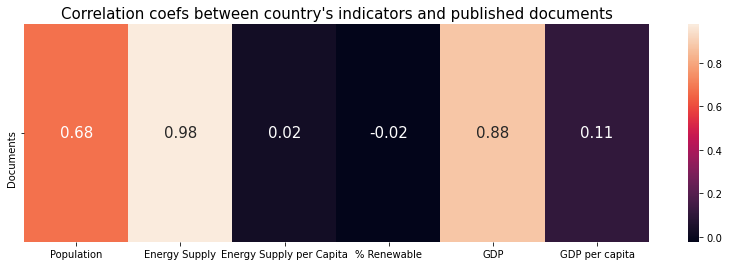

In [251]:
plt.figure(figsize=(14, 4))

# Choosing the columns and the rows of our correlation matrix
Doc_columns = ['Documents']
Indicators = ['Population', 'Energy Supply','Energy Supply per Capita', '% Renewable', 'GDP', 'GDP per capita']

# We can efficient visualize those coefficients using a heatmap
sns.heatmap(df2013.corr().loc[Doc_columns, Indicators], annot = True, fmt='.2f', annot_kws={'fontsize' : 15})
plt.title("Correlation coefs between country's indicators and published documents", fontsize = 15);

`Energy Supply` and `GDP` seems to be the best ones here. They are the country's indicators that have the most information to determine the `amount of documents in Energy` this country has published.
But is it really surprising? One can understand that countries with a high GDP generally have bigger markets and interests thus it makes sense that more documents are written by them.

Choosing the `number of documents` as a target might not be the best choice if we want to discover something relatively new as **it is clearly not scaled**.

The amount of `citations` highly depends on the amount of `documents`, so both will surely behave in the same manner. It seems unwise to choose it as well.

We are left with : `Documents per Capita`, `Citations per Document`, `H index`. Let's see their correlation coefficients with previously selected features 


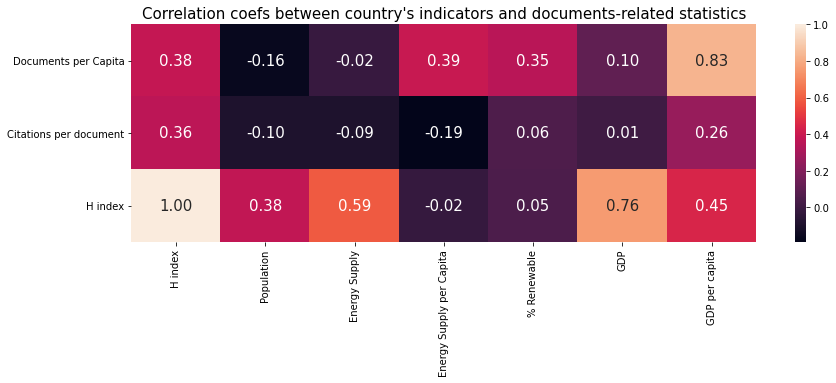

In [252]:
plt.figure(figsize=(14, 4))
Doc_columns = ['Documents per Capita', 'Citations per document', 'H index']
Indicators = ['H index', 'Population', 'Energy Supply','Energy Supply per Capita', '% Renewable', 'GDP', 'GDP per capita']

sns.heatmap(df2013.corr().loc[Doc_columns, Indicators], annot = True, fmt='.2f', annot_kws={'fontsize' : 15})
plt.title("Correlation coefs between country's indicators and documents-related statistics", fontsize = 15);

`H index` is by definition a combination of these others features so these coefficients attached to him aren't suprising.

`Citations per document` doesn't have any highly correlated feature and `Documents per Capita` seems to have a bit more.

We will then focus on this last one.


## Feature extraction

Let's see if we can reach a better correlation coefficient by combining the features in the x-axis.

`Documents per Capita` has an interesting coefficient with `% renewable` (the percentage of renewable energy in the country's energy supply). This is rather unexpected and this feature **might capture exclusive information**. Let's try to extract a good augmented feature combining `% renewable` with another raw feature.

To be sure that features have exclusive information towards each other, we look at their correlation matrix (2nd graph)

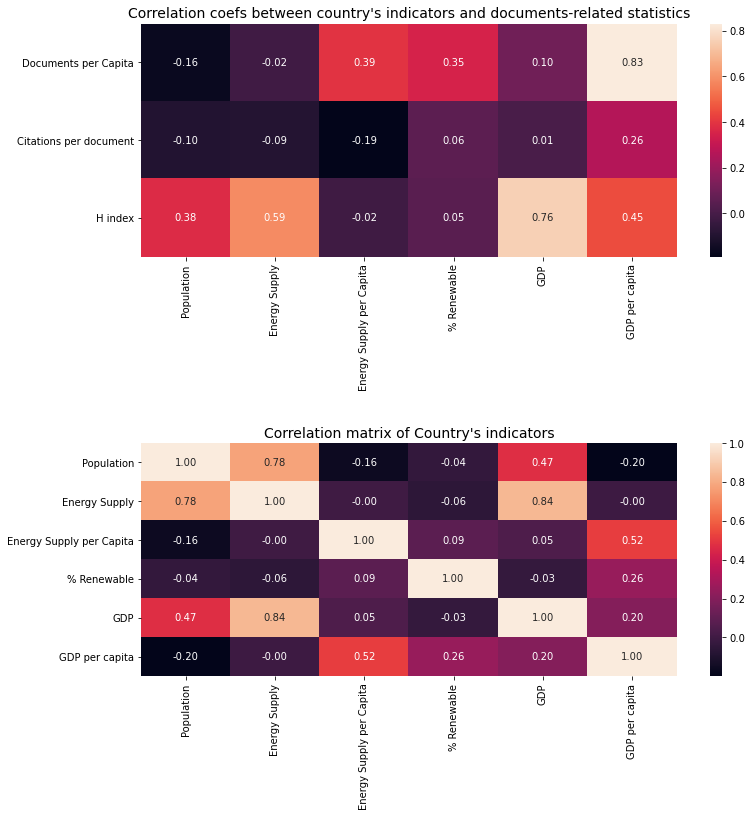

In [257]:
fig, axes = plt.subplots(2, 1, figsize=(12,12))
fig.subplots_adjust(hspace=0.8)

Doc_columns = ['Documents per Capita', 'Citations per document', 'H index']
Indicators = ['Population', 'Energy Supply','Energy Supply per Capita', '% Renewable', 'GDP', 'GDP per capita']

sns.heatmap(df2013.corr().loc[Doc_columns, Indicators], annot = True, fmt = '.2f', ax = axes[0])
sns.heatmap(df2013.corr().loc[Indicators, Indicators], annot = True, fmt = '.2f', ax = axes[1])

axes[1].set_title("Correlation matrix of Country's indicators", fontsize = 14)
axes[0].set_title("Correlation coefs between country's indicators and documents-related statistics", fontsize = 14);

This shows us straightaway that some combination of features (those where features to combine themselves are correlated towards each other) are pointless.

However, if we look closely at the coefficient between `% Renewable` and `Energy Supply per Capita`, it is quite small but have relatively good coefs with `Documents per Capita`. It seems like a good candidate for a combination.


We can use **PCA (with one component)** to find the direction such that once the two features are projected on it, the waste of information due to this compression is minimized.

Let's define now the function **Coef_combined_feature** that will take as input the features to combine, apply PCA and return the correlation coefficient between the new feature and Documents per Capita.

In [266]:
def Coef_combined_feature(Raw_features):

    # We scale first the data to allow the pca to find the direction oh highest variance effectively
    # Features will now be scaled with 0 mean and unit variance

    scaled = StandardScaler().fit_transform(Raw_features)

    pca = PCA(n_components=1).fit(scaled) # We have now this direction

    # Our new feature by projecting our data on this direction
    New_feature = pca.transform(scaled)

    #Let's return its correlation with "Documents per capita"
    return pearsonr(New_feature.reshape(len(New_feature)), df2013['Documents per Capita'])[0]    


####  PCA with `Energy Supply per Capita` and `% Renewable`

In [267]:
Coef_combined_feature(df2013[['% Renewable', 'Energy Supply per Capita']])

0.5048689131903583

Much better now than coefs of both of these individual features!! We see that from supposedly "weak" predictors, we can build a stronger one. What if we add for example, `GDP` ??

####  PCA with `Energy Supply per Capita` ,  `% Renewable` and  `GDP`

In [268]:
Coef_combined_feature(df2013[['% Renewable', 'Energy Supply per Capita', 'GDP']])

0.5147143579923101

The coef increases. `GDP` does bring more information. Even if it is not that correlated with the final target `Documents per Capita`(0.1), its information is not included in both `% Renewable` and `Energy Supply per Capita` as shown in the correlation matrix above.

We will add up now `GDP per Capita` which has a coef of 0.83 with `Documents per Capita`.

####  PCA with `Energy Supply per Capita` ,  `% Renewable`,  `GDP` and `GDP per Capita`


In [271]:
Coef_combined_feature(df2013[['% Renewable', 'Energy Supply per Capita', 'GDP', 'GDP per capita']])

0.7372087642605165

The coef is better than the previous one but worse than `GDP per Capita` which was individually at 0.83 with `Documents per Capita`.
It makes senses as `GDP per Capita` is quite corelated with others indicators (0.52 with `Energy Supply per Capita` !!). 
**There is a redundancy of information**, thus the overall coefficient gets affected.
In this case, it will be better to just keep `GDP per Capita` as the only predictor instead.


What if we decide to seek the direction such that when the data points are projected on it, the correlation is maximized?
To do so , let's perform the **Canonical Correlation Analysis (CCA)**.

In [273]:
# Finding the right direction with CCA
cca = CCA(n_components=1).fit(df2013[['% Renewable', 'Energy Supply per Capita', 'GDP', 'GDP per capita']],
                              df2013['Documents per Capita'])

# Our new feature
EnergyXRen2, _ = cca.transform(df2013[['% Renewable', 'Energy Supply per Capita', 'GDP', 'GDP per capita']],
                               df2013['Documents per Capita'])

#Let's print its correlation with "Documents per Capita"
print('Coefficient with CCA : ',pearsonr(EnergyXRen2.reshape(len(EnergyXRen2)), df2013['Documents per Capita'])[0])


Coefficient with CCA :  0.8455082130356664


Nice! Quite better than `GDP per Capita` individually. It is explainable because CCA is able to give a 0 weight to features than are irrelevant while looking for optimal direction.


In [285]:
print('CCA weights : ', list(zip(['% Renewable', 'Energy Supply per Capita', 'GDP', 'GDP per capita'],
                                 cca.x_weights_[:, 0])))

CCA weights :  [('% Renewable', 0.16711527044702618), ('Energy Supply per Capita', -0.052658802681366586), ('GDP', -0.06660929612860782), ('GDP per capita', 0.982274268497772)]


`GDP per Capita` has indeed the highest weight and features too correlated with him have weights close to zero.